<a href="https://colab.research.google.com/github/Atharva-Gaykar/Deep_Learning/blob/main/notebooks/image_data/CNN_leaf_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub


path = kagglehub.dataset_download("aryashah2k/mango-leaf-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mango-leaf-disease-dataset


In [ ]:
import os

dataset_path = "/kaggle/input/mango-leaf-disease-dataset"


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import cv2
from os import listdir
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D,AveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization, Activation,
    LeakyReLU, PReLU
)

from tensorflow.keras.optimizers import Adam

In [ ]:
data_classes = os.listdir(dataset_path)
data_classes

['Powdery Mildew',
 'Cutting Weevil',
 'Anthracnose',
 'Bacterial Canker',
 'Sooty Mould',
 'Gall Midge',
 'Healthy',
 'Die Back']

In [ ]:
img_dt=[]
for dt_class in data_classes:
    class_dir = os.path.join(dataset_path , dt_class)
    if os.path.isdir(class_dir):
        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img_dt.append((os.path.join(dt_class, filename), dt_class))


In [ ]:
work_dt = pd.DataFrame(img_dt, columns=['filename', 'class_target'])


work_dt

,filename,class_target
0,Powdery Mildew/IMG_20211107_124627 (Custom).jpg,Powdery Mildew
1,Powdery Mildew/IMG_20211107_125226 (Custom).jpg,Powdery Mildew
2,Powdery Mildew/IMG_20211107_125656 (Custom).jpg,Powdery Mildew
3,Powdery Mildew/IMG_20211107_125157 (Custom).jpg,Powdery Mildew
4,Powdery Mildew/20211109_121933 (Custom).jpg,Powdery Mildew
...,...,...
3995,Die Back/20211129_164057 (Custom).jpg,Die Back
3996,Die Back/20211129_161101 (Custom).jpg,Die Back
3997,Die Back/20211129_161846 (Custom).jpg,Die Back
3998,Die Back/20211129_162852 (Custom).jpg,Die Back


In [ ]:
from sklearn.model_selection import train_test_split


train_df, temp_df = train_test_split(work_dt, test_size=0.30, stratify=work_dt["class_target"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["class_target"], random_state=42)


print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")



Train samples: 2800
Validation samples: 600
Test samples: 600


In [ ]:
train_df

,filename,class_target
2529,Gall Midge/IMG_20211106_164328 (Custom).jpg,Gall Midge
3036,Healthy/20211231_160913 (Custom).jpg,Healthy
3894,Die Back/IMG_20211028_003123 (Custom).jpg,Die Back
1148,Anthracnose/IMG_20211011_164127 (Custom).jpg,Anthracnose
3413,Healthy/20211231_160949 (Custom).jpg,Healthy
...,...,...
308,Powdery Mildew/IMG_20211107_121440 (Custom).jpg,Powdery Mildew
2420,Sooty Mould/IMG_20211108_120948 (Custom).jpg,Sooty Mould
2953,Gall Midge/IMG_20211106_163303 (Custom).jpg,Gall Midge
1461,Anthracnose/IMG_20211011_152941 (Custom).jpg,Anthracnose


<ipython-input-9-94f3f606891e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x="class_target", palette='viridis')
<ipython-input-9-94f3f606891e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=val_df, x="class_target", palette='viridis')
<ipython-input-9-94f3f606891e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=test_df, x="class_target", palette='viridis')


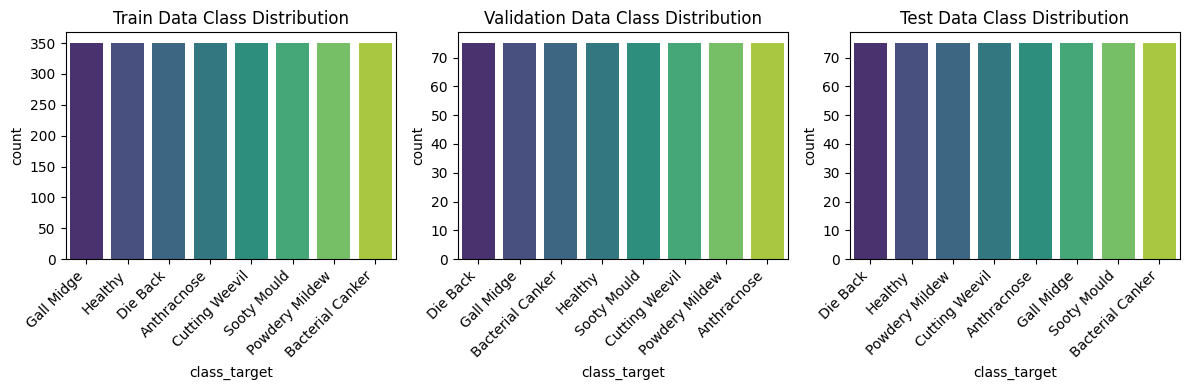

In [ ]:


plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.countplot(data=train_df, x="class_target", palette='viridis')
plt.title("Train Data Class Distribution")
plt.xticks(rotation=45, ha='right')
plt.subplot(1, 3, 2)
sns.countplot(data=val_df, x="class_target", palette='viridis')
plt.title("Validation Data Class Distribution")
plt.xticks(rotation=45, ha='right')
plt.subplot(1, 3, 3)
sns.countplot(data=test_df, x="class_target", palette='viridis')
plt.title("Test Data Class Distribution")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=dataset_path,
    x_col='filename',
    y_col='class_target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)
validation_generator = val_datagen.flow_from_dataframe(
    val_df,
    directory=dataset_path,
    x_col='filename',
    y_col='class_target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=dataset_path,
    x_col='filename',
    y_col='class_target',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2800 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.
Found 600 validated image filenames belonging to 8 classes.


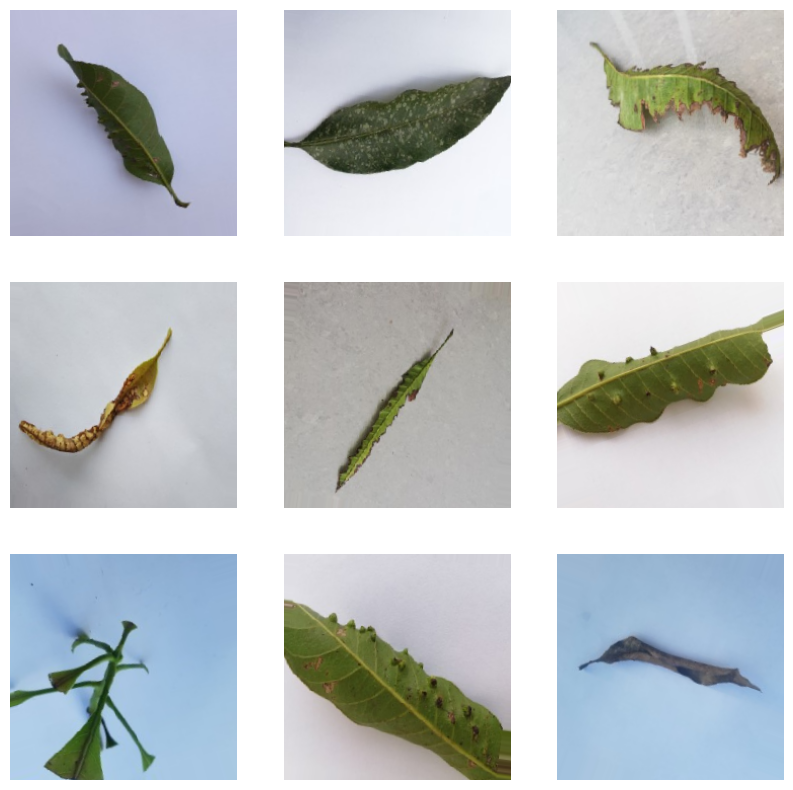

In [ ]:
preview_dt = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(preview_dt[0][i])
    plt.axis('off')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

def create_model_CNN(layers, dropout_rate, n_classes, activation="leakyrelu",
                 learning_rate=0.01, l2_reg=0.01): # Adjusted default l2_reg
    # Load Pretrained ResNet50 without the top layers
    conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    conv_base.trainable = False  # Freeze convolutional base

    model = Sequential()
    model.add(conv_base)
    model.add(Flatten())  # Flatten extracted features

    # Fully Connected Layers
    for nodes in layers:
        model.add(Dense(nodes, kernel_initializer=tf.keras.initializers.HeUniform(),
                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        model.add(BatchNormalization())

        # Activation Choices
        if activation == "prelu":
            model.add(PReLU())
        elif activation == "leakyrelu":
            model.add(LeakyReLU(alpha=0.01))
        else:
            model.add(Activation(activation))

        # Apply Dropout if specified
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(n_classes, activation='softmax'))

    # Compile Model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
layers = [1024,256] # Reduced dense layer sizes significantly
dropout_rate = 0.35
n_classes = 8
learning_rate = 0.00001

# Create the model
model = create_model_CNN(layers, dropout_rate, n_classes, learning_rate=learning_rate)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │   102,761,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,618,760 (483.01 MB)

 Trainable params: 103,028,488 (393.02 MB)

 Non-trainable params: 23,590,272 (89.99 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

In [ ]:
# prompt: plot model history

# Plot model history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:

from keras.applications.vgg19 import VGG19


def create_model_CNN2(layers, dropout_rate, n_classes, activation="leakyrelu",
                      learning_rate=0.01, l2_reg=0.01):  # Adjusted default l2_reg

    # Load pre-trained VGG19 model
    conv_base_2 = VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Set trainability for specific layers
    conv_base_2.trainable = True
    set_trainable = False

    for layer in conv_base_2.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        layer.trainable = set_trainable

    # Print layer trainability status
    for layer in conv_base_2.layers:
        print(layer.name, layer.trainable)

    # Create model
    model = Sequential()
    model.add(conv_base_2)
    model.add(Flatten())  # Flatten extracted features

    # Fully Connected Layers
    for nodes in layers:
        model.add(Dense(nodes, kernel_initializer=tf.keras.initializers.HeUniform(),
                        kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
        model.add(BatchNormalization())

        # Activation Choices
        if activation == "prelu":
            model.add(PReLU())
        elif activation == "leakyrelu":
            model.add(LeakyReLU(alpha=0.01))
        else:
            model.add(Activation(activation))

        # Apply Dropout if specified
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(n_classes, activation='softmax'))

    # Compile Model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
layers = [512] # Reduced dense layer sizes significantly
dropout_rate = 0.1
n_classes = 8
learning_rate = 0.00001
l2_reg = 0.0001 # Changed variable name to match function argument and set a small float value

# Create the model
model2 = create_model_CNN2(layers, dropout_rate, n_classes, learning_rate=learning_rate, l2_reg=l2_reg) # Pass l2_reg
model2.summary()

input_layer_8 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,876,104 (125.41 MB)

 Trainable params: 22,289,928 (85.03 MB)

 Non-trainable params: 10,586,176 (40.38 MB)

In [ ]:
history2 = model2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    verbose=1,callbacks=[early_stopping],
)

Epoch 1/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 56s 590ms/step - accuracy: 0.4601 - loss: 1.6507 - val_accuracy: 0.5233 - val_loss: 1.3518
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 48s 547ms/step - accuracy: 0.8995 - loss: 0.4774 - val_accuracy: 0.8783 - val_loss: 0.6070
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 48s 545ms/step - accuracy: 0.9468 - loss: 0.3075 - val_accuracy: 0.9583 - val_loss: 0.3266
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 49s 559ms/step - accuracy: 0.9608 - loss: 0.2315 - val_accuracy: 0.9667 - val_loss: 0.2228
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 80s 537ms/step - accuracy: 0.9724 - loss: 0.2006 - val_accuracy: 0.9767 - val_loss: 0.1793
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 545ms/step - accuracy: 0.9814 - loss: 0.1738 - val_accuracy: 0.9883 - val_loss: 0.1590
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 47s 530ms/step - accuracy: 0.9873 - loss: 0.1534 - val_accuracy: 0.9900 - val_loss: 0.1399
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 49s 558ms/step - accuracy: 0.9925 - loss: 0.1354 - val_accu

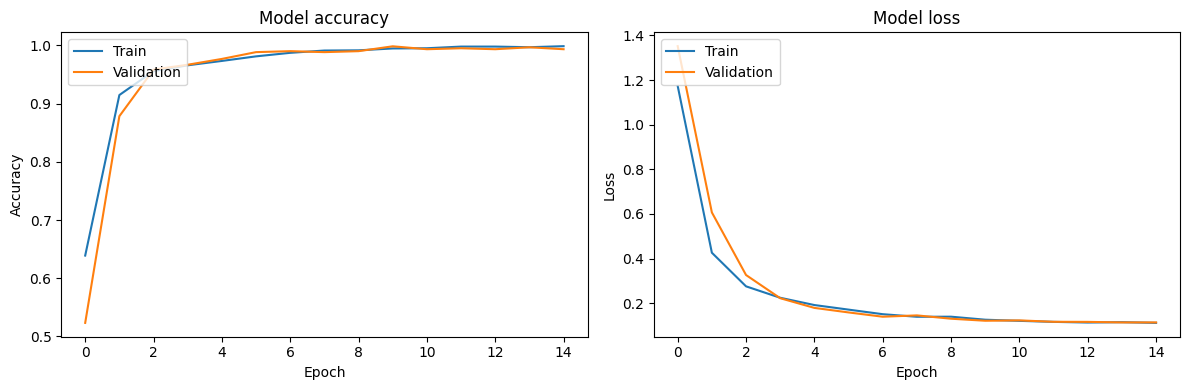

In [ ]:

plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:


test_loss2, test_acc2 = model2.evaluate(test_generator, verbose=0)
print(f"Model 2 Test Accuracy: {test_acc2:.4f}")
print(f"Model 2 Test Loss: {test_loss2:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Model 2 Test Accuracy: 0.9950
Model 2 Test Loss: 0.1186


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step


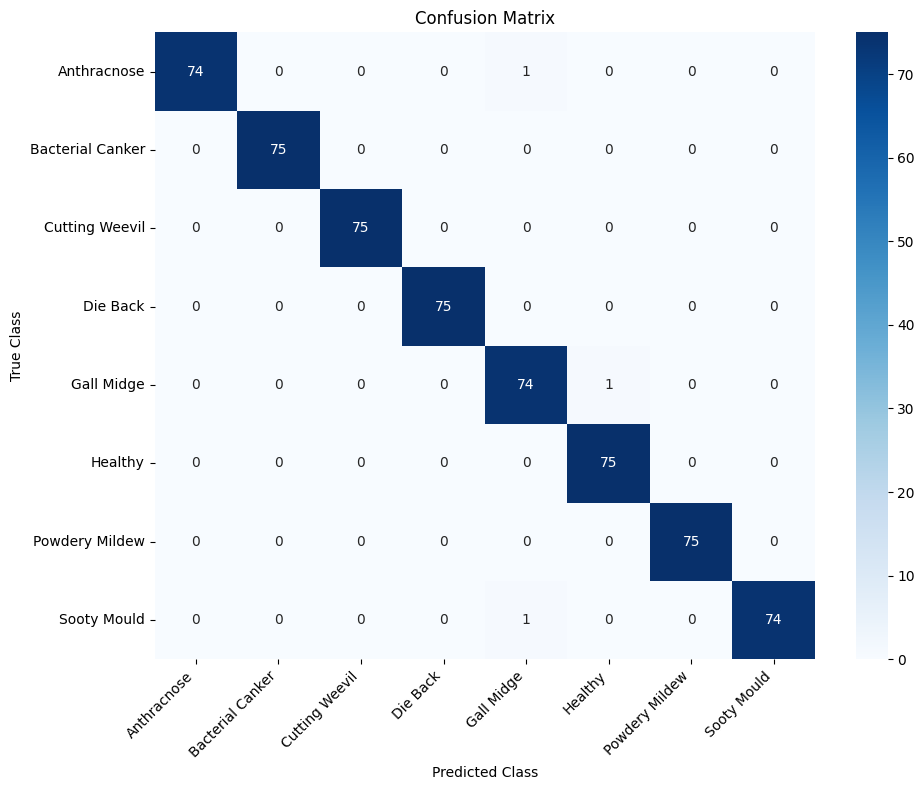

In [ ]:


from sklearn.metrics import confusion_matrix


y_pred_probs2 = model2.predict(test_generator)
y_pred_classes2 = np.argmax(y_pred_probs2, axis=1)
y_true_classes = test_generator.classes


class_labels = list(test_generator.class_indices.keys())


cm = confusion_matrix(y_true_classes, y_pred_classes2)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

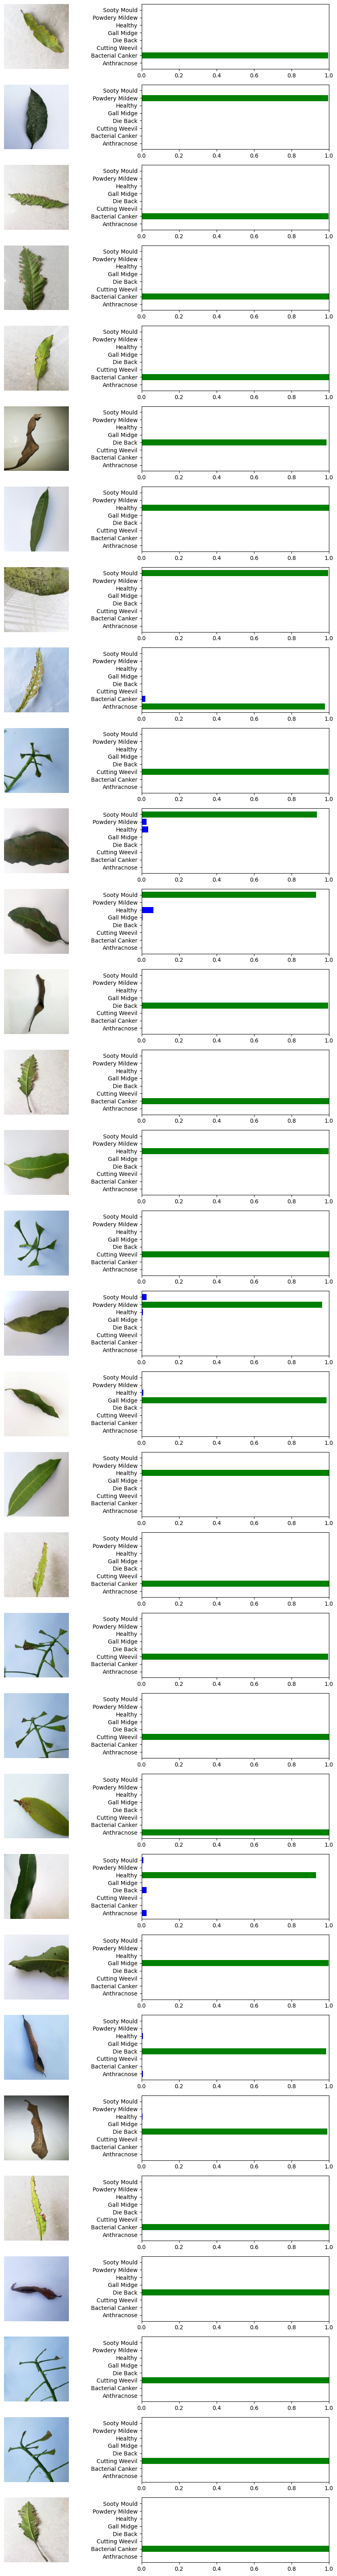

In [ ]:
def output_plot_batch(images, model, class_labels):
    batch_size = len(images)
    fig, axs = plt.subplots(batch_size, 2, figsize=(10, 2 * batch_size))

    for i, image in enumerate(images):
        predictions = model.predict(image.reshape(1, 224, 224, 3))
        prediction_values = predictions[0]
        max_index = np.argmax(prediction_values)
        colors = ['green' if j == max_index else 'blue' for j in range(len(class_labels))]


        axs[i, 0].imshow(array_to_img(image))
        axs[i, 0].axis('off')


        axs[i, 1].barh(class_labels, prediction_values, color=colors)
        axs[i, 1].set_xlim([0, 1])

    plt.tight_layout()
    plt.show()


test_images, test_labels = next(test_generator)


class_labels = list(test_generator.class_indices.keys())

# Call the modified function
output_plot_batch(test_images, model2, class_labels)